In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
from skimage.util import random_noise
from torchvision import transforms
from qst_nn.ops import gaus2d, add_state_noise
from qst_nn.ops import cat, num, thermal_dm, binomial, coherent_dm, fock_dm, gkp
from torch import nn
from qutip.wigner import qfunc
from qst_nn.utils import add_photon_noise
from qst_nn.utils import plot_husimi_directly, plot_three_husimi
import matplotlib.pyplot as plt

hilbert_size = 32
grid_size = 32
device = torch.device("cuda")
print(f"Using {device} device")

xvec = np.linspace(-5, 5, 32)
yvec = np.linspace(-5, 5, 32)

tensor_x = torch.Tensor(torch.load('data.pt')) # transform to torch tensor
tensor_y = torch.Tensor(torch.load('label.pt'))

tensor_x = torch.unsqueeze(tensor_x, dim=1)
#torch_dataset = TensorDataset(tensor_x, tensor_y) # create your dataset

nth = 3 # Thermal photon number (determines the Gaussian convolution)
X, Y = np.meshgrid(xvec, yvec) #get 2D variables instead of 1D
gauss_kernel = gaus2d(X, Y, n0=nth)

class MixedStateNoise(object):
    """Add mixed state noise to image.

    Args:
        amount (int): Desired pepper noise amount. Suggested decent amount is =< 0.5.
    """
    def __init__(self, 
                 sigma=0.5,
                 sparsity=0.8):
        assert isinstance(sigma, float)
        assert isinstance(sparsity, float)
        self.sigma = sigma
        self.sparsity = sparsity        
        self.function_list = [fock_dm, coherent_dm, thermal_dm, 
                              num, binomial, cat, gkp]

    def __call__(self, sample):
        rho = self.function_list[sample[1].to(dtype=torch.long)](hilbert_size)
        rho_mixed = add_state_noise(rho[0], sigma=self.sigma, sparsity=self.sparsity)
        data_mixed = torch.Tensor(qfunc(rho_mixed, xvec, yvec, g=2)).to(dtype=torch.float)
        return data_mixed, sample[1]

class GaussianConvolutionTransformation(object):
    """
    Expectation layer that calculates expectation values for a set of operators on a batch of rhos.
    You can specify different sets of operators for each density matrix in the batch.
    """
    def __init__(self, 
                 kernel):
        self.kernel = kernel[None, None, :, :]

    def __call__(self, sample):
        """Expectation function call
        """
        return nn.functional.conv2d(torch.unsqueeze(sample[0], dim=0), 
                                    torch.from_numpy(self.kernel).to(dtype=torch.float),  
                                    padding='same'), sample[1]
    
class PhotonLossNoise(object):
    """Add photon loss noise to image.

    Args:
        amount (int): Desired pepper noise amount. Suggested decent amount is =< 0.5.
    """

    def __init__(self, 
                 gamma=0.05,
                 tlist=None):
        assert isinstance(gamma, float)
        self.gamma = gamma       
        self.function_list = [fock_dm, coherent_dm, thermal_dm, 
                              num, binomial, cat, gkp]
        self.tlist = tlist

    def __call__(self, sample):
        rho = self.function_list[sample[1].to(dtype=torch.long)](hilbert_size)
            
        if self.tlist: photon_loss_states = add_photon_noise(rho[0], gamma=self.gamma, tlist=self.tlist)
        else:
            tlist = np.linspace(0, 1000, 2000)
            photon_loss_states = add_photon_noise(rho[0], gamma=self.gamma, tlist=tlist)
                
        rho_photon_loss = photon_loss_states[555]
        data_photon_loss = torch.Tensor(qfunc(rho_photon_loss, xvec, yvec, g=2)).to(dtype=torch.float)
            
        return data_photon_loss, sample[1]

class PepperNoise(object):
    """Add pepper noise to image.

    Args:
        amount (int): Desired pepper noise amount. Suggested decent amount is =< 0.5.
    """

    def __init__(self, 
                 amount=0.5):
        assert isinstance(amount, float)
        self.amount = amount

    def __call__(self, sample):
        return torch.Tensor(random_noise(sample[0], 
                                         mode="pepper", 
                                         amount = self.amount)).to(dtype=torch.float), sample[1]
    
class AffineTransformation(object):
    """Add pepper noise to image.

    Args:
        amount (int): Desired pepper noise amount. Suggested decent amount is =< 0.5.
    """

    def __init__(self, 
                 degree,
                 shear=5):
        self.degree = degree
        self.shear = shear

    def __call__(self, sample):
        return transforms.RandomAffine(self.degree, shear=self.shear)(torch.unsqueeze(sample[0], dim=0)), sample[1]

class GaussianNoiseTransformation(object):
    """Add Gaussian noise to image.

    Args:
        std (int): Standard devitation. Suggested is =< 0.2 as in paper.
    """

    def __init__(self, 
                 std,
                 mean=0.):
        assert isinstance(std, float)
        assert isinstance(mean, float)
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        x= sample[0]/torch.max(sample[0])
        return x + torch.randn(x.size())*self.std + self.mean, sample[1]

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, 
                 tensors, 
                 transform=None):
        
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        sample = [self.tensors[0][index], self.tensors[1][index]]
        
        if (self.transform and sample[1] != 7):
            selected = transforms.RandomApply(self.transform)
            sample = selected(sample)
            
        return sample[0], sample[1]

    def __len__(self):
        return self.tensors[0].size(0)
'''
trans = [MixedStateNoise(),
        GaussianConvolutionTransformation(gauss_kernel),
        PhotonLossNoise(),
        AffineTransformation(100),
        GaussianNoiseTransformation(0.2),
        PepperNoise()]

torch_dataset = CustomTensorDataset((tensor_x, tensor_y), transform=trans)

train_size = int(0.8 * len(torch_dataset))
test_size = len(torch_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(torch_dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=128) # create your dataloader
test_dataloader = DataLoader(test_dataset, batch_size=128)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
'''

2022-12-23 02:02:30.855680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 02:02:30.977290: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-23 02:02:31.418416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-23 02:02:31.418462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Using cuda device


'\ntrans = [MixedStateNoise(),\n        GaussianConvolutionTransformation(gauss_kernel),\n        PhotonLossNoise(),\n        AffineTransformation(100),\n        GaussianNoiseTransformation(0.2),\n        PepperNoise()]\n\ntorch_dataset = CustomTensorDataset((tensor_x, tensor_y), transform=trans)\n\ntrain_size = int(0.8 * len(torch_dataset))\ntest_size = len(torch_dataset) - train_size\ntrain_dataset, test_dataset = torch.utils.data.random_split(torch_dataset, [train_size, test_size])\ntrain_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=128) # create your dataloader\ntest_dataloader = DataLoader(test_dataset, batch_size=128)\n\nfor X, y in test_dataloader:\n    print(f"Shape of X [N, C, H, W]: {X.shape}")\n    print(f"Shape of y: {y.shape} {y.dtype}")\n    break\n'

/home/ccl/qst-nn-venv/src/qst-nn/qst_nn/utils.py:415: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(xvec, yvec, x, cmap=cmap, norm=norm)


torch.Size([32, 32])
torch.Size([1, 32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([1, 32, 32])
torch.Size([32, 32])


(<Figure size 104.095x104.095 with 2 Axes>,
 <AxesSubplot:title={'center':'Gaussian additive noise'}, xlabel='Re($\\beta$)', ylabel='Im$(\\beta)$'>)

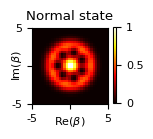

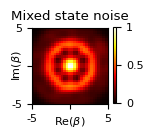

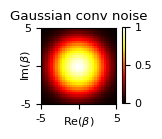

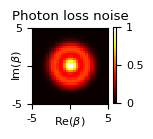

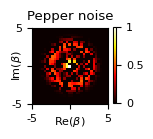

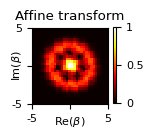

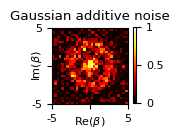

In [4]:
rho, mu = binomial(hilbert_size)
original_bin = qfunc(rho, xvec, yvec, g=2)
plot_husimi_directly(original_bin, cmap='hot', title="Normal state")

original_bin = torch.from_numpy(original_bin).to(dtype=torch.float)
mixed, _ = MixedStateNoise()([original_bin, torch.tensor(4)])
print(mixed.shape)
plot_husimi_directly(mixed.numpy(), cmap='hot', title="Mixed state noise")

gauconv, _ = GaussianConvolutionTransformation(gauss_kernel)([original_bin, torch.tensor(4)])
print(gauconv.shape)
plot_husimi_directly(torch.squeeze(gauconv, dim=0).numpy(), cmap='hot', title="Gaussian conv noise")

photonloss, _ = PhotonLossNoise()([original_bin, torch.tensor(4)])
print(photonloss.shape)
plot_husimi_directly(photonloss.numpy(), cmap='hot', title="Photon loss noise")

pepper, _ = PepperNoise()([original_bin, torch.tensor(4)])
print(pepper.shape)
plot_husimi_directly(pepper.numpy(), cmap='hot', title="Pepper noise")

affine, _ = AffineTransformation(100)([original_bin, torch.tensor(4)])
print(affine.shape)
plot_husimi_directly(torch.squeeze(affine, dim=0).numpy(), cmap='hot', title="Affine transform")

gauadd, _ = GaussianNoiseTransformation(0.2)([original_bin, torch.tensor(4)])
print(gauadd.shape)
plot_husimi_directly(gauadd.numpy(), cmap='hot', title="Gaussian additive noise")

In [2]:
class GaussianNoise(nn.Module):
    """Apply additive zero-centered Gaussian noise.
    This is useful to mitigate overfitting
    (you could see it as a form of random data augmentation).
    Gaussian Noise (GS) is a natural choice as corruption process
    for real valued inputs.
    As it is a regularization layer, it is only active at training time.
    Args:
      stddev: Float, standard deviation of the noise distribution.
    Call arguments:
      inputs: Input tensor (of any rank).
    Input shape:
      Arbitrary. Use the keyword argument `input_shape`
      (tuple of integers, does not include the samples axis)
      when using this layer as the first layer in a model.
    Output shape:
      Same shape as input.
    """

    def __init__(self, 
                 std, 
                 mean=0.):
        super().__init__()
        self.mean = mean
        self.std = std
        
    def forward(self, x):
        return x + torch.randn(x.size(), device=device)*self.std + self.mean


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, bias=False)
        self.leaky_relu = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, 3, bias=False)
        self.drop_out = nn.Dropout(p=0.4)
        self.noise = GaussianNoise(0.005)
        self.conv3 = nn.Conv2d(32, 32, 3, bias=False, stride=2)
        self.conv4 = nn.Conv2d(32, 64, 3, bias=False)
        self.conv5 = nn.Conv2d(64, 64, 3, bias=False)
        self.conv6 = nn.Conv2d(64, 64, 3, bias=False, stride=2)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 8)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.noise(x)
        x = self.drop_out(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = self.noise(x)
        x = self.drop_out(x)
        x = self.conv5(x)
        x = self.leaky_relu(x)
        x = self.conv6(x)
        x = self.leaky_relu(x)
        x = self.drop_out(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.leaky_relu(x)
        x = self.drop_out(x)
        x = self.linear2(x)
        x = self.leaky_relu(x)
        x = self.linear3(x)
        
        return x
model = Classifier()
model.to(device)

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (drop_out): Dropout(p=0.4, inplace=False)
  (noise): GaussianNoise()
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=8, bias=True)
)

In [3]:
loss = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.9))

In [4]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).type(torch.LongTensor)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.to(device), y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).type(torch.LongTensor)
            pred = model(X)
            test_loss += loss_fn(pred.to(device), y.to(device)).item()
            correct += (pred.argmax(-1).to(device) == y.to(device)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss, optimizer)
    test(test_dataloader, model, loss)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same